# Model Building and Development Phase

### Steps to be followed after data preprocessing:
1. Data splitting into training/validation/holdout paritions 
2. Selection of models to be tested under cross validation 
3. Reduce the dimensions of the data using Principal components analysis
4. 10-Fold CV on training partition to check for in-sample accuracy 
5. Fit the models on training set and evaluate performance using validation set (still in-sample data)
6. Re-assess models after feature elimination / dimension reduction using 10-Fold CV 
7. Repeat step 4 
8. Optimize the learning models using evolutionary GA search (GridSearch removed due to extremely high complexity time)
9. Re-assess the models after fitting them
10. Generate performance metrics (Confusion matrix, ROC curve, feature importance bar-plot, train-test accuracy graph)
11. Fit these models in an ensemble stack and then assess their combined predicitive metrics
12. Assess the ensemble stack against RNN

In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import sklearn as sk 
import rpy2

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

matplotlib.rcParams.update({'font.size': 40})

plt.style.use('seaborn-bright')

In [2]:
class ModelBuilder:
    pass #No class attribute needed

    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train #Instance attributes 
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test 

    #Data scaling using MinMax
    def data_scaler(self, Xtrain_cols, Xtest_cols, needs_training_as_scaled=True):
        scaler = MinMaxScaler(feature_range=(-1,1)).fit(self.X_train)
        if needs_training_as_scaled is True:
            X_train_scaled = scaler.transform(self.X_train)
            scaled_df_train = pd.DataFrame(X_train_scaled, columns=Xtrain_cols)
            return scaled_df_train
        elif needs_training_as_scaled is not True:
            X_test_scaled = scaler.transform(self.X_test)
            scaled_df_test = pd.DataFrame(X_test_scaled, columns=Xtest_cols)
            return scaled_df_test
    
    #Data standardization using StandardScaler
    def data_standardizer(self, Xtrain_cols, Xtest_cols, needs_training_as_scaled=True):
        standardizer = StandardScaler().fit(self.X_train)
        if needs_training_as_scaled is True:
            X_train_standard = standardizer.transform(self.X_train)
            standard_df_train = pd.DataFrame(X_train_standard, columns=Xtrain_cols)
            return standard_df_train
        elif needs_training_as_scaled is not True:
            X_test_standard = standardizer.transform(self.X_test)
            standard_df_test = pd.DataFrame(X_test_standard, columns=Xtrain_cols)
            return X_test_standard

    #10-fold cross validation on the scaled data 
    def cross_validator(self, model, X_train_scaled, n_folds=10, has_scaled_data=True):
        if has_scaled_data != True:
            raise ValueError('Data not scaled. Scale data first')
        else:
            model_cv = cross_val_score(model, X_train_scaled, self.y_train, cv=n_folds, scoring='accuracy')
            print('10 Fold CV scores: ', model_cv)
            print('Mean 10-fold CV score: ', np.mean(model_cv))

    
    #Model fitter after data scaling on learning algorithms  
    def model_fitter(self, model, X_train_scaled, X_test_scaled, is_scaled=True):
        if is_scaled != True:
            raise ValueError("Data not scaled.")
        
        if is_scaled == True:
            model.fit(X_train_scaled, self.y_train)
            predictions = model.predict(X_test_scaled, self.y_test)
            metric = accuracy_score(self.y_test, predictions)
            print('Classification score: ', metric)

### Loading in the dataset after preprocessing

In [3]:
df = pd.read_csv('/home/sauraj/Desktop/Notebooks/Research/newspy.csv')

In [4]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,5-DayEMA,20-DayEMA,Real Lower Band,Real Middle Band,Real Upper Band,MACD,MACD_Hist,MACD_Signal,SlowD,SlowK,CCI,OBV,EMA_Reversal,Returns,MarketTrend,EMA_Trend_Down,EMA_Trend_Reversal,EMA_Trend_Up,StoReversal_NoReversal,StoReversal_Reversal,MACDTrend_Down,MACDTrend_Reversal,MACDTrend_Up,OBVTrend_Down,OBVTrend_Up,CCITrend_NoReversal,CCITrend_Reversal
0,1998-02-23,104.250000,103.343697,104.250000,104.062500,3227800,71.191544,103.899979,103.869506,96.2644,100.8570,105.4496,2.0341,0.1147,1.9194,87.2955,88.3007,114.5056,39995300,0.030473,-0.003904,2,0,1,0,1,0,0,0,1,0,1,0,1
1,1998-02-24,104.093697,102.937500,103.906197,103.250000,3386800,70.635689,103.592094,103.642027,97.1356,101.2258,105.3159,1.9688,0.0395,1.9293,85.9809,78.9543,93.2333,36608500,-0.049933,0.007869,2,0,1,0,1,0,0,1,0,1,0,1,0
2,1998-02-25,104.875000,103.625000,103.750000,104.531197,3481800,71.512207,103.982183,103.898717,97.8045,101.6101,105.4158,1.9974,0.0545,1.9429,80.9184,75.5002,124.9737,40090300,0.083466,-0.012257,2,0,1,0,1,0,0,1,0,0,1,0,1
3,1998-02-26,105.218697,104.187500,104.437500,105.125000,3187600,71.918427,104.420895,104.195344,98.3230,101.9805,105.6379,2.0444,0.0812,1.9632,77.2805,77.3869,140.6155,43277900,0.225551,-0.005649,2,0,0,1,1,0,0,1,0,0,1,0,1
4,1998-02-27,105.531197,104.531197,104.968697,105.125000,3442900,71.918427,104.678184,104.391459,98.8459,102.3242,105.8025,2.0580,0.0758,1.9822,80.6615,89.0974,140.6006,43277900,0.286725,0.000000,2,0,0,1,1,0,0,1,0,0,1,0,1


In [5]:
#Resetting the index to datetime index
df = df.set_index('Date')

In [6]:
#Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5245 entries, 1998-02-23 to 2018-12-24
Data columns (total 33 columns):
High                      5245 non-null float64
Low                       5245 non-null float64
Open                      5245 non-null float64
Close                     5245 non-null float64
Volume                    5245 non-null int64
Adj Close                 5245 non-null float64
5-DayEMA                  5245 non-null float64
20-DayEMA                 5245 non-null float64
Real Lower Band           5245 non-null float64
Real Middle Band          5245 non-null float64
Real Upper Band           5245 non-null float64
MACD                      5245 non-null float64
MACD_Hist                 5245 non-null float64
MACD_Signal               5245 non-null float64
SlowD                     5245 non-null float64
SlowK                     5245 non-null float64
CCI                       5245 non-null float64
OBV                       5245 non-null int64
EMA_Reversal           

# Data Partition and Dimension Reduction (PCA)

## Data Partition

In [7]:
train = df[:4196]
test = df[4196:]

In [8]:
#Obtain the predictor variables and input features 
X = train.drop(['MarketTrend'], axis=1)
y = train['MarketTrend']

In [9]:
#Obtain train and validation samples from the train partition 
from sklearn.model_selection import train_test_split

#Shuffle parameter set to false to avoid data shuffling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=44)

## Dimension Reduction 

After the dataset has been split into training and testing, feature reduction is to be done so as to 

1. Reduce the number of input features to be used for model building, with the main goal of reducing model overfitting 

2. To remove redundant features which may not have a significant impact on the predictor variable and hence add onto model complexity.

### Data Normalization 

Normalization is performed before running PCA in order to bring all features on the same numeric scaling.

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [9]:
#Data standardizing for dimensionality reduction
mms = StandardScaler()
mms.fit(X_train)
X_train_scaled = mms.transform(X_train)
X_test_scaled = mms.transform(X_test)

/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/sauraj/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/home/sauraj/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [10]:
#Scaling for neural network 
minmax = MinMaxScaler()
minmax.fit(X_train)
nn_Xtrain = minmax.transform(X_train)
nn_Xtest = minmax.transform(X_test)

/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Principal Components Analysis 

PCA is a feature reduction algorithm which reduces the dimensions of a dataset by finding linear combinations of vectors which explain the maximum amount of the variance present in the dataset. By performing orthogonal rotation, PCA not only reduces the number of feature vectors present in the vector space but also decorrelates all the features to bring their correlation to each other at 0.

The selection of the number of principal components is done on a few criterias:

1. No. of components which can explain the maximum variation (Eigenvalue criterion)
2. Percentage of variance explained (Maximal variance criterion)



In [11]:
from sklearn.decomposition import PCA, FactorAnalysis
pca = PCA(n_components=9).fit(X_train_scaled)
pca_Xtrain = pca.transform(X_train_scaled)
pca_Xtest = pca.transform(X_test_scaled)

Let's check for the respective eigenvalues of the components and the variance explained by each eigenvalue

In [12]:
pca_Xtrain

array([[ 2.35164882, -3.01668374,  0.84805866, ..., -0.6590501 ,
        -0.94061593,  5.9416306 ],
       [ 2.47550709, -2.06818591, -2.86096194, ...,  0.49000607,
         0.71821988,  5.59328368],
       [ 2.3150237 , -2.53373499,  0.63806414, ..., -0.64216366,
         1.07718334,  6.14051577],
       ...,
       [-1.16662546,  3.27705146,  1.67725748, ...,  0.30762277,
        -1.09058413, -0.56902699],
       [-1.60070318,  1.82822757,  1.84324713, ...,  1.34614807,
         1.16931051, -0.22552699],
       [-1.62424152,  1.7712315 , -0.96643468, ...,  1.29036837,
         1.4123841 , -0.11343235]])

In [16]:
pca.explained_variance_

array([10.19807871,  7.34565073,  2.58584956,  2.33491611,  2.20832064,
        1.49756461,  1.37209947,  1.17369541,  1.02251005])

Looks like 5 components can easily explain around 84.67% of the variance in the dataset. Hence, we need to extract 5 components from the dataset through PCA

In [13]:
Xtrain_cols = X_train.columns
Xtest_cols = X_test.columns

In [14]:
pca.explained_variance_ratio_[0:8]*100

array([31.85949985, 22.94831851,  8.07837203,  7.29443866,  6.8989457 ,
        4.67849492,  4.28653318,  3.66670525])

In [15]:
len(pca.components_)

9

The next question is, which features represent which particular component?

In [16]:
pcacomp_df = pd.DataFrame(pca.components_,columns=Xtrain_cols, index=['PC1','PC2','PC3','PC4','PC5', 'PC6','PC7','PC8', 'PC9']).T

In [17]:
#The transpose matrix reveals the 5 principal components which have been extracted from the dataset
pcacomp_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
High,-0.307564,0.058394,0.008802,-0.011154,0.029491,-0.053875,-0.010380,0.024649,-0.000095
Low,-0.309202,0.048730,0.006073,-0.007051,0.016340,-0.054259,-0.011209,0.025893,0.003265
Open,-0.308044,0.056193,-0.005096,-0.006882,0.028066,-0.052623,-0.011694,0.025129,0.002035
Close,-0.308729,0.050450,0.023891,-0.012682,0.016678,-0.054962,-0.010575,0.024375,0.000432
Volume,0.055243,0.071268,0.075272,0.029299,0.182691,0.503474,0.336812,-0.348664,-0.065680
Adj Close,-0.290620,0.040974,0.042367,0.012391,0.034453,0.189602,0.139013,-0.120108,-0.015459
5-DayEMA,-0.306933,0.066496,0.001832,-0.005262,0.019629,-0.049833,-0.011397,0.022015,-0.000113
20-DayEMA,-0.299761,0.100387,0.013270,-0.015617,0.036194,-0.040149,-0.010866,0.032866,0.001423
Real Lower Band,-0.300236,0.096988,-0.000384,-0.006798,-0.010505,-0.020750,-0.026953,0.032709,0.010033
Real Middle Band,-0.297747,0.109202,0.013606,-0.015331,0.028937,-0.032186,-0.017597,0.033382,0.000490


Text(0, 0.5, 'Principal Component 2')

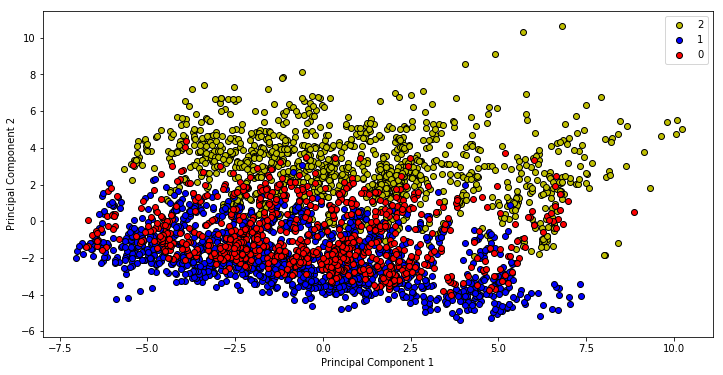

In [18]:
#Plotting the PCA plot on a 2d space 
target_ids = range(len(y_train))

plt.figure(figsize=(12, 6))
for i, c, label in zip(target_ids, 'ybr', y_train.unique()):
    plt.scatter(pca_Xtrain[y_train == i, 0], pca_Xtrain[y_train == i, 1],
               c=c, edgecolor='black', label=label, linewidth='1')
plt.legend(loc='best')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.savefig('pcaplot.png', dpi=400)

In [19]:
pca.explained_variance_ratio_*100

array([31.85949985, 22.94831851,  8.07837203,  7.29443866,  6.8989457 ,
        4.67849492,  4.28653318,  3.66670525,  3.19439177])

Text(0, 0.5, '% Variance explained')

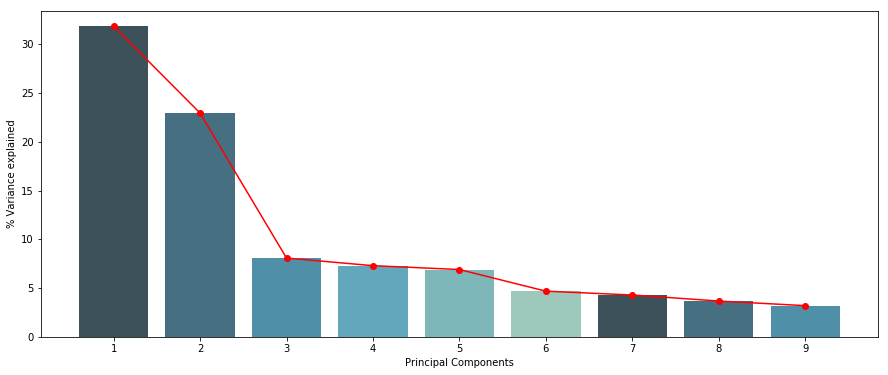

In [20]:
pallette = sns.color_palette("GnBu_d")
plt.figure(figsize=(15,6))
sns.barplot(np.arange(1, 10), pca.explained_variance_ratio_*100, palette=pallette)
plt.plot(pca.explained_variance_ratio_*100, 'ro-')
plt.xlabel('Principal Components')
plt.ylabel('% Variance explained')
#plt.savefig('varianceexplained.png', dpi=400)

### Varimax Rotation PCA 

Varimax Rotation PCA is a subset of PCA where instead of the orthogonal basis sitting at a different coordinate space, it is rotated to align with the coordinates of the vector space. The reason this was done was due to the fact that Orthogonal PCA was producing components which did not hold significant amounts of correlation with their respective components, hence the eigenvectors were rotated by using varimax rotation.

###### The extraction of the components was done in R using "psych" library's "principal()" function with rotation as "varimax". Varimax rotation was done in Python to obtain the new principal components after varimax rotation.

In [21]:
def varimax(Phi, gamma = 1.0, q = 50, tol = 1e-6):
    from scipy import eye, asarray, dot, sum, diag
    from scipy.linalg import svd
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    return dot(Phi, R)

In [22]:
#Varimax rotated principal components 
pca_Xtrain2 = varimax(pca_Xtrain)
pca_Xtest2 = varimax(pca_Xtest)

## Cross validation and model tuning 

The next step is to run cross-validation and assess the model accuracy using K-fold validation, k = 10

In [23]:
#The base classifiers 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#Cross validation modules
from sklearn.model_selection import cross_val_score, cross_val_predict

#Instantiate the models 
svc = SVC(gamma=0.1, C=1, kernel='rbf')
rfc = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=7)

class cv_library:
    pass 
    
    def cross_val_metrics(clf):
        scores = cross_val_score(clf, pca_Xtrain2, y_train, cv=10, scoring='accuracy') #pca_Xtrain2 is varimax rotated
        scores_mean = np.mean(scores)
        scores_stdev = np.std(scores)
        return scores, scores_mean, scores_stdev

    def cv_plotter(clf):
        scores = cross_val_score(clf, pca_Xtrain2, y_train, cv=10, scoring='accuracy')
        plt.plot(scores, 'bo-')
        plt.xlim([0, 10])
        plt.show()

In [30]:
svc_cvscores = cross_val_score(svc, pca_Xtrain, y_train, cv=10, scoring='accuracy')
knn_cvscores = cross_val_score(knn, pca_Xtrain, y_train, cv=10, scoring='accuracy')
rfc_scores = cross_val_score(rfc, pca_Xtrain, y_train, cv=10, scoring='accuracy')

In [31]:
svc_cvscores

array([0.77380952, 0.76785714, 0.78869048, 0.80952381, 0.80952381,
       0.79166667, 0.7797619 , 0.82686567, 0.80298507, 0.7994012 ])

In [32]:
knn_cvscores

array([0.75892857, 0.74702381, 0.75297619, 0.76190476, 0.63690476,
       0.7202381 , 0.75297619, 0.8119403 , 0.81791045, 0.76047904])

In [33]:
rfc_scores

array([0.85416667, 0.83333333, 0.79761905, 0.81547619, 0.81547619,
       0.85119048, 0.85119048, 0.82686567, 0.85373134, 0.92215569])

In [36]:
xyz = []
accuracy = []
std = []
classifiers = ["SVC", "RandomForests", "KNN"]

models = [svc, rfc, knn]

for model in models:
    cv_results = cross_val_score(model, pca_Xtrain, y_train, cv=10)
    xyz.append(cv_results.mean())
    std.append(cv_results.std())
    accuracy.append(cv_results)

cv_df = pd.DataFrame({'CV Mean':xyz, 'Deviation': std}, index=classifiers)

In [100]:
print(cv_df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &   CV Mean &  Deviation \\
\midrule
SVC           &  0.795009 &   0.017290 \\
RandomForests &  0.844202 &   0.032720 \\
KNN           &  0.752128 &   0.047368 \\
\bottomrule
\end{tabular}



Text(0, 0.5, 'Accuracy per fold')

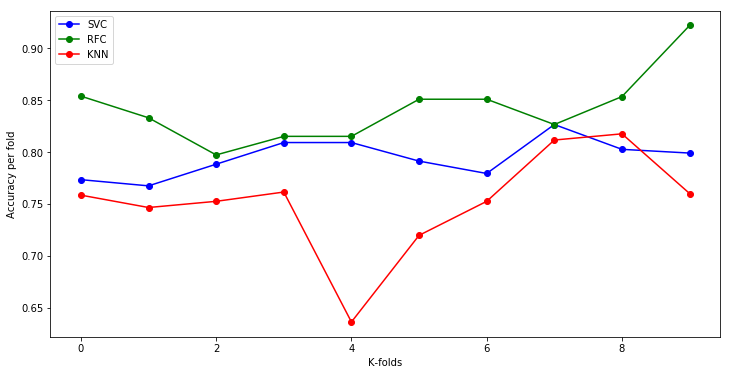

In [34]:
plt.figure(figsize=(12,6))
plt.plot(svc_cvscores, 'bo-')
plt.plot(rfc_scores, 'go-')
plt.plot(knn_cvscores, 'ro-')
plt.legend(("SVC", "RFC", "KNN"))
plt.xlabel('K-folds')
plt.ylabel('Accuracy per fold')
#plt.savefig('cv2.png', dpi=300)

Text(0, 0.5, 'CV scores')

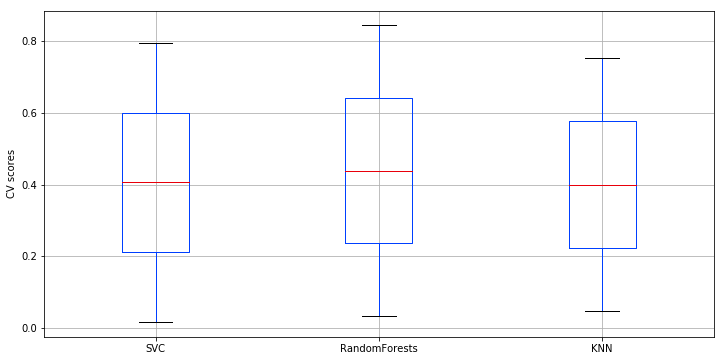

In [37]:
plt.figure(figsize=(12,6))
cv_df.T.boxplot()
plt.ylabel('CV scores')
#plt.savefig('boxcv.png', dpi=300)

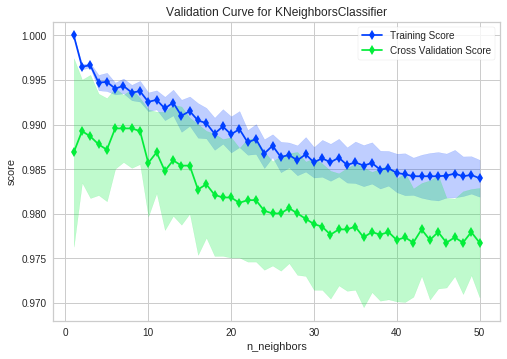

In [481]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(knn, param_name="n_neighbors", param_range=np.arange(1, 51), cv=5, scoring='accuracy')

viz.fit(pca_Xtrain2, y_train)
viz.poof()

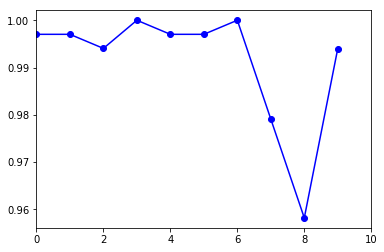

In [23]:
cv_library.cv_plotter(svc)

In [38]:
#Plotting the graph of CV scores
scores3, mean, dev_ = cv_library.cross_val_metrics(knn)

In [39]:
plt.figure(figsize=(15,6))
ticks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.plot(scores, 'bo-')
plt.plot(scores2, 'ro-')
plt.plot(scores3, 'go-')
plt.legend(("Support Vector Classifier", "RandomForestClassifier", "KNN"))
plt.xlabel('No. of Folds in Cross-validation')
plt.ylabel('Validation accuracy scores')
#plt.savefig('cv.png', dpi=300)

NameError: name 'scores' is not defined

<Figure size 1080x432 with 0 Axes>

In [40]:
models = [svc, rfc, knn]

average = []
deviation = []
for model in models:
    mean, stdev = cv_library.cross_val_metrics(model)
    average.append(mean)
    deviation.append(stdev)

ValueError: too many values to unpack (expected 2)

In [41]:
print('Mean scores of 10-fold CV for the three classifiers: ', average)
print('\n Standard deviation of the scores: ', deviation)

Mean scores of 10-fold CV for the three classifiers:  []

 Standard deviation of the scores:  []


## Predicting the output for the classifiers on the testing dataset and comparing their accuracy

In [24]:
def predict(clf):
    clf.fit(pca_Xtrain2, y_train)
    scores = clf.predict(pca_Xtest2)
    accuracy = accuracy_score(y_test, scores)
    print("Accuracy score of the classifier chosen: ", accuracy)

In [25]:
#Prediction score for Random Forests
predict(rfc)

Accuracy score of the classifier chosen:  0.8107142857142857


In [26]:
#Prediction score for SVC
predict(svc)

Accuracy score of the classifier chosen:  0.5928571428571429


In [27]:
#Prediction score for K-nearest neighbors
predict(knn)

Accuracy score of the classifier chosen:  0.7488095238095238


FeatureImportances(absolute=False,
          ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f41c0714898>,
          labels=Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'], dtype='object'),
          model=None, relative=True, stack=False, xlabel=None)

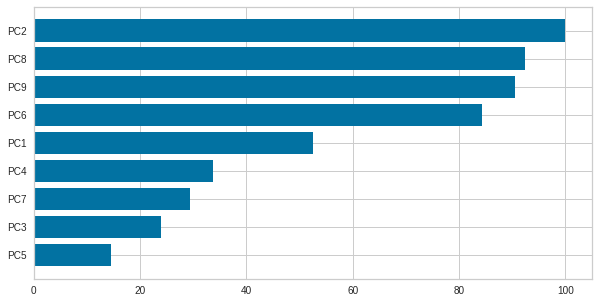

In [28]:
from yellowbrick.features.importances import FeatureImportances

plt.figure(figsize=(10,5))
viz = FeatureImportances(rfc, labels=pcacomp_df.columns)
viz.fit(pca_Xtrain2, y_train)
#viz.poof(outpath="features.png")

## Learning Curves of the three classifiers

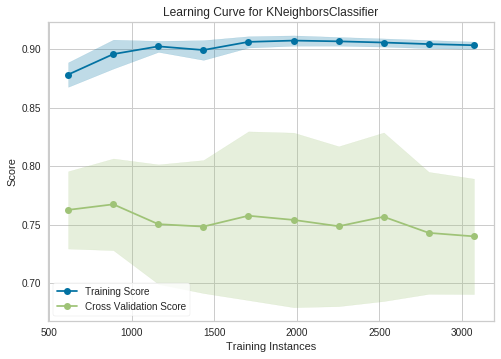

In [58]:
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import StratifiedKFold

sizes = np.linspace(0.2, 1.0, 10)
cv = StratifiedKFold(12)
viz = LearningCurve(knn, cv=cv, train_sizes=sizes)
viz.fit(pca_Xtrain, y_train)
viz.poof()

Turns out that the best performing classifier in the current problem is Random forests, with an accuracy of 81.54% on 100 estimators, followed by KNN with 5 nearest neighbors and lastly, SVC with a 71.7% accuracy with polynomial kernel.

##### The next step in the model building process is to take the base classifiers and optimize their parameters using hyperparameter tuning

### Hyperparameter Tuning 

In [652]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#Grid tuning for KNN (because it is the fastest to optimize)
neighbors = np.arange(1, 51)
metric = ['euclidean','minkowski']
weight = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree','kd_tree','brute']
params = {
    'n_neighbors':neighbors,
    'metric': metric,
    'weights': weight,
    'algorithm': algorithm
    
}

gd = RandomizedSearchCV(estimator=KNeighborsClassifier(), param_distributions=params,cv=10,  verbose=True)
gd.fit(pca_Xtrain2, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.9889749702026222
{'weights': 'distance', 'n_neighbors': 5, 'metric': 'euclidean', 'algorithm': 'auto'}


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.9s finished


In [29]:
#Grid tuning for RandomForest classifier 
n_estimators = np.arange(10, 310, 10)
criterion = ['gini','entropy']
max_depth = np.arange(1, 11)
min_samples_split = [0.1, 0.3, 0.7, 1.0]
min_samples_leaf = [1, 2, 3, 4, 5]

rf_params = {
    'n_estimators': n_estimators,
    'criterion': criterion,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

gd = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=rf_params, verbose=True, cv=10)
gd.fit(pca_Xtrain2, y_train)
print(gd.best_score_)
print(gd.best_params_)

NameError: name 'RandomizedSearchCV' is not defined

In [631]:
#Grid search for Support vector classifier 
C = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
kernel = ['rbf','poly','sigmoid']
degree = np.arange(1, 11)
gamma = np.linspace(0, 0.03125, 100)
decision_function_shape = ['ovo','ovr']

svc_params = {
    'C': C,
    'kernel': kernel,
    'degree': degree, 
    'gamma': gamma,
    'decision_function_shape': decision_function_shape
}

gd = RandomizedSearchCV(estimator=SVC(), param_distributions=svc_params, cv=10)
gd.fit(pca_Xtrain2, y_train)
print(gd.best_score_)
print(gd.best_params_)

0.9997020262216925
{'kernel': 'sigmoid', 'gamma': 0.010732323232323234, 'degree': 8, 'decision_function_shape': 'ovo', 'C': 0.2}


In [30]:
knn2 = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='distance', algorithm='auto')
knn2.fit(pca_Xtrain2, y_train)
preds = knn2.predict(pca_Xtest2)
print('Accuracy score after optimization:', accuracy_score(y_test, preds))

Accuracy score after optimization: 0.7333333333333333


In [31]:
rfc2 = RandomForestClassifier(n_estimators=70, min_samples_split=0.1, min_samples_leaf=3, max_depth=10)
rfc2.fit(pca_Xtrain2, y_train)
preds2 = rfc2.predict(pca_Xtest2)
print('Accuracy score after optimization:', accuracy_score(y_test, preds2))

Accuracy score after optimization: 0.8761904761904762


In [32]:
svc2 = SVC(kernel='sigmoid', degree=8, decision_function_shape='ovr', C=0.20, gamma=0.010732323232323234)
svc2.fit(pca_Xtrain2, y_train)
preds3 = svc2.predict(pca_Xtest2)
print('Accuracy score after optimization:', accuracy_score(y_test, preds3))

Accuracy score after optimization: 0.7976190476190477


### Performance metrics of base classifiers after optimization 

The three metrics which will be used to evaluate the three classifiers are 

* Confusion matrix 
* ROC AUC 
* Precision-Recall curve

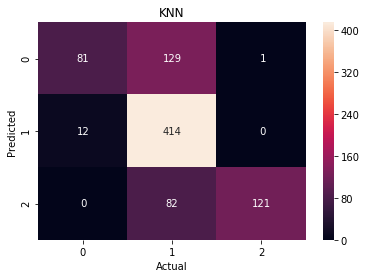

In [59]:
#Confusion matrix for KNN 
from sklearn.metrics import confusion_matrix
knn2.fit(pca_Xtrain2, y_train)
knn_predictions = knn2.predict(pca_Xtest2)
sns.heatmap(confusion_matrix(y_test, knn_predictions), annot=True, fmt='2.0f')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title("KNN")
plt.savefig("knncf.png", dpi=400)

Text(33.0, 0.5, 'Predicted')

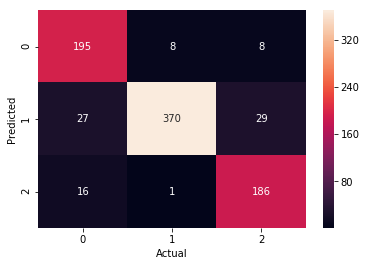

In [60]:
#Confusion matrix for RandomForests
rfc2.fit(pca_Xtrain2, y_train)
rfc_predictions = rfc2.predict(pca_Xtest2)
sns.heatmap(confusion_matrix(y_test, rfc_predictions), annot=True, fmt='1.0f')
plt.xlabel('Actual')
plt.ylabel('Predicted')

Text(33.0, 0.5, 'Predicted')

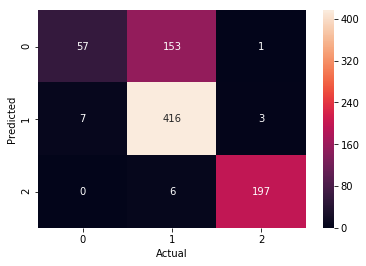

In [61]:
#Confusion matrix for SVC
svc2.fit(pca_Xtrain2, y_train)
svc_predictions = svc2.predict(pca_Xtest2)
sns.heatmap(confusion_matrix(y_test, svc_predictions), annot=True, fmt='1.0f')
plt.xlabel('Actual')
plt.ylabel('Predicted')

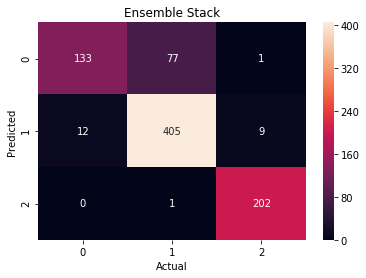

In [62]:
#Confusion matrix for XGBoost 
from sklearn.metrics import confusion_matrix
xgc2.fit(pca_Xtrain2, y_train)
xgc2_predictions = xgc2.predict(pca_Xtest2)
sns.heatmap(confusion_matrix(y_test, xgc2_predictions), annot=True, fmt='1.0f')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title("Ensemble Stack")
plt.savefig('stackcf.png', dpi=400)

In [33]:
#Calculating the sensitivity and specificity metrics of each confusion matrix for matrix analysis 
from sklearn.metrics import classification_report

In [34]:
#Classifier report for SVC 
print(classification_report(y_test, preds3))

              precision    recall  f1-score   support

           0       0.89      0.27      0.41       211
           1       0.72      0.98      0.83       426
           2       0.98      0.97      0.98       203

   micro avg       0.80      0.80      0.80       840
   macro avg       0.86      0.74      0.74       840
weighted avg       0.83      0.80      0.76       840



In [35]:
#Classifier report for RandomForests
print(classification_report(y_test, preds2))

              precision    recall  f1-score   support

           0       0.77      0.93      0.84       211
           1       0.97      0.83      0.90       426
           2       0.85      0.92      0.88       203

   micro avg       0.88      0.88      0.88       840
   macro avg       0.86      0.89      0.87       840
weighted avg       0.89      0.88      0.88       840



In [53]:
#Classifier report for KNN
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.87      0.38      0.53       211
           1       0.66      0.97      0.79       426
           2       0.99      0.60      0.74       203

   micro avg       0.73      0.73      0.73       840
   macro avg       0.84      0.65      0.69       840
weighted avg       0.79      0.73      0.71       840



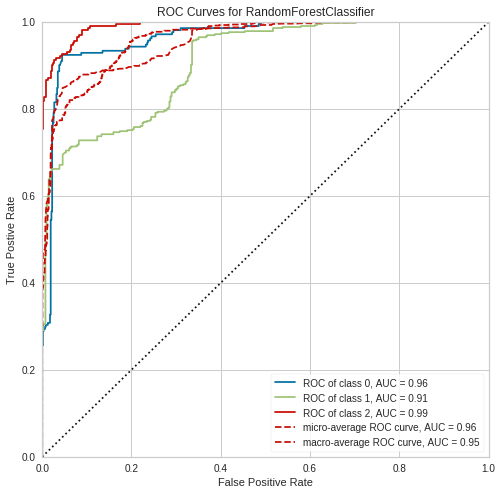

In [241]:
from yellowbrick.classifier import ROCAUC
plt.figure(figsize=(8,8))
visualizer = ROCAUC(rfc2)
visualizer.fit(pca_Xtrain2, y_train)  # Fit the training data to the visualizer
visualizer.score(pca_Xtest2, y_test)# Evaluate the model on the test data
g = visualizer.poof()# Draw/show/poof the data

In [38]:
#Xtreme gradient boosting 

xgc = xgb.XGBClassifier()
xgc.fit(pca_Xtrain2, y_train)
preds4 = xgc.predict(pca_Xtest2)

In [39]:
print("Accuracy with XGBoost('Pre-optimization'): ", accuracy_score(y_test, preds4))

Accuracy with XGBoost('Pre-optimization'):  0.8095238095238095


In [40]:
xgc2_params = xgc2.get_params()
xgc2_params['num_class'] = 3

NameError: name 'xgc2' is not defined

In [37]:
#Parameter tuning for XGBoost
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

boosters = ['gbtree', 'dart']
eta = np.linspace(0.1, 0.3, 20)
gamma = np.linspace(0, 1, 10)
max_depth = [1, 2, 3, 4, 5]
scale_pos_weight = [1, 2, 3]
objective = ["multi:softmax", "multi:pairwise"]
n_estimators = np.arange(0, 1100, 100)


xgb_params = {
    'booster': boosters,
    'eta': eta,
    'gamma': gamma,
    'max_depth': max_depth,
    'scale_pos_weight': scale_pos_weight,
    'objective': objective,
    'n_estimators': n_estimators,
    'num_class': 3
}

#gd = RandomizedSearchCV(estimator=XGBClassifier(), param_distributions=xgb_params, cv=5)
#gd.fit(pca_Xtrain2, y_train)
#print(gd.best_score_)
#print(gd.best_params_)

In [41]:
dtrain = xgb.DMatrix(pca_Xtrain2, label=y_train)
dtest = xgb.DMatrix(pca_Xtest2, label=y_test)

In [42]:
dtrain.feature_types

In [43]:
xgc2 = XGBClassifier(scale_pos_weight=2, objective='multi:softmax', max_depth=2, gamma=0.10, eta=0.14210526315789473, booster='gbtree', n_estimators=200, num_class=3)

xgc2.fit(pca_Xtrain2, y_train)
xgc2_predictions = xgc2.predict(pca_Xtest2)
accuracy_score(y_test, xgc2.predict(pca_Xtest2))

0.8809523809523809

Text(51.0, 0.5, 'Predicted')

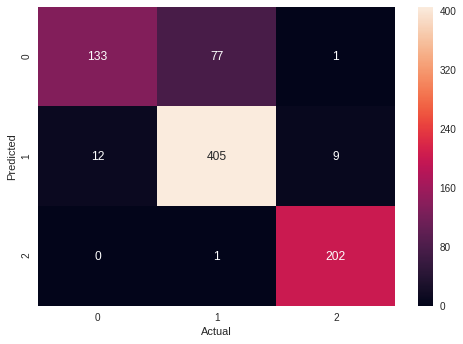

In [183]:
sns.heatmap(confusion_matrix(y_test, xgc2.predict(pca_Xtest2)), annot=True, fmt='1.0f')
plt.xlabel('Actual')
plt.ylabel('Predicted')

## Neural Network 

In [44]:
LabelBinarizer?

Object `LabelBinarizer` not found.


In [45]:
#Binarize the class labels for the neural network 
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(y_train)
Y = lb.transform(y_train)
Y_test = lb.transform(y_test)

In [46]:
Y_test

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0]])

In [56]:
#Keras neural network modules 
from keras import Sequential 
from keras.optimizers import Adagrad
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint


callbacks = [EarlyStopping(monitor='val_loss'),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
adagrad = Adagrad(lr=0.035)
model = Sequential()
model.add(Dense(12, input_dim=nn_Xtrain.shape[1], activation='softmax'))
model.add(Dense(16, activation='softmax'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=adagrad, metrics=['accuracy'])
history = model.fit(nn_Xtrain, Y, epochs=100, validation_data=(nn_Xtest, Y_test), callbacks=callbacks)

Train on 3356 samples, validate on 840 samples
Epoch 1/100
3356/3356 [==============================] - 1s 228us/step - loss: 0.8997 - acc: 0.7160 - val_loss: 0.7423 - val_acc: 0.7583
Epoch 2/100
3356/3356 [==============================] - 0s 61us/step - loss: 0.6573 - acc: 0.7530 - val_loss: 0.6216 - val_acc: 0.7583
Epoch 3/100
3356/3356 [==============================] - 0s 73us/step - loss: 0.5653 - acc: 0.7530 - val_loss: 0.5725 - val_acc: 0.7583
Epoch 4/100
3356/3356 [==============================] - 0s 57us/step - loss: 0.5238 - acc: 0.7530 - val_loss: 0.5452 - val_acc: 0.7583
Epoch 5/100
3356/3356 [==============================] - 0s 74us/step - loss: 0.5009 - acc: 0.7530 - val_loss: 0.5300 - val_acc: 0.7583
Epoch 6/100
3356/3356 [==============================] - 0s 74us/step - loss: 0.4866 - acc: 0.7530 - val_loss: 0.5204 - val_acc: 0.7583
Epoch 7/100
3356/3356 [==============================] - 0s 100us/step - loss: 0.4770 - acc: 0.7530 - val_loss: 0.5132 - val_acc: 0.7583

### Score on the validation data

In [57]:
scores = model.predict_classes(nn_Xtest)
accuracy_score(y_test, scores)

0.8095238095238095

In [58]:
scores_probs = model.predict(nn_Xtest)

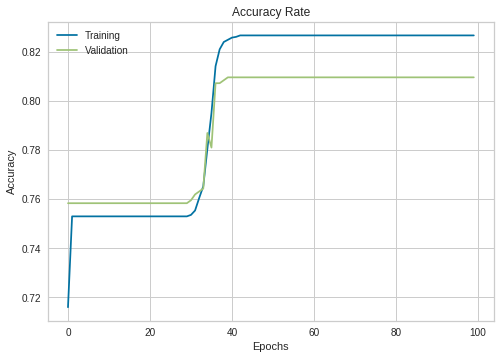

In [59]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy Rate')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(("Training","Validation"))
#plt.savefig('acc.png', dpi=400)

In [389]:
predictions = predictions_nn.round()

### Confusion matrix for the validation dataset

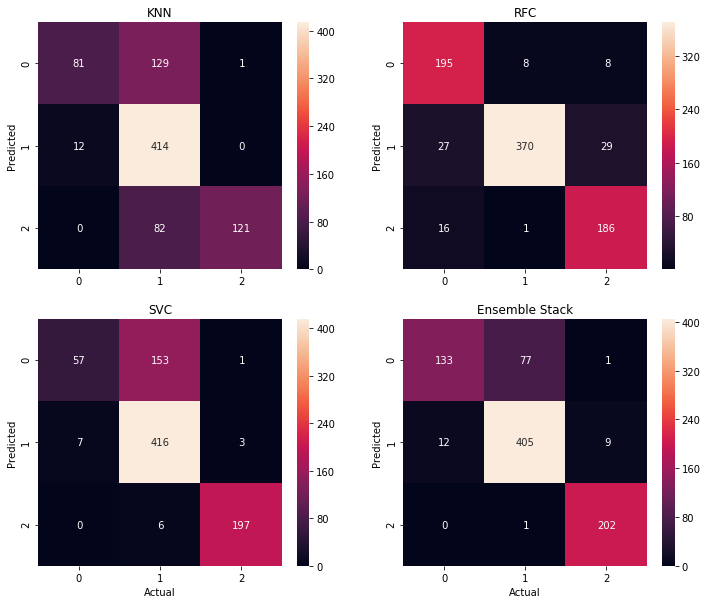

In [81]:
f,ax=plt.subplots(2,2,figsize=(12,10))
#KNN
sns.heatmap(confusion_matrix(y_test, knn_predictions), annot=True, fmt='2.0f', ax=ax[0,0])
ax[0,0].set_ylabel('Predicted')
ax[0,0].set_title('KNN')

#RFC
sns.heatmap(confusion_matrix(y_test, rfc_predictions), annot=True, fmt='2.0f', ax=ax[0,1])
ax[0,1].set_ylabel('Predicted')
ax[0,1].set_title('RFC')

#SVC
sns.heatmap(confusion_matrix(y_test, svc_predictions), annot=True, fmt='2.0f', ax=ax[1,0])
ax[1,0].set_ylabel('Predicted')
ax[1,0].set_xlabel('Actual')
ax[1,0].set_title('SVC')

#Stack 
sns.heatmap(confusion_matrix(y_test, xgc2_predictions), annot=True, fmt='2.0f', ax=ax[1,1])
ax[1,1].set_ylabel('Predicted')
ax[1,1].set_xlabel('Actual')
ax[1,1].set_title('Ensemble Stack')

plt.savefig('confusion.png', dpi=400)

# Hypothesis Testing


The last and final stage of the model building process is to run the hypothesis test and determine if there is a significatn differnece between the performance metrics of the two classifiers. 

The test used for determining the score is the *Two samples proportions test*

$$z = \frac{\hat{p1} - \hat{p2}}{\sqrt{2\hat{p}(1-\hat{p})/n}}$$

**where** $$\hat{p} = (x_{1} + x_{2}) / 2n$$
$$ \hat{p1} = \text{Proportion of values correctly identified by classifier 1}$$
$$ \hat{p2} = \text{Proportion of values correctly identified by classifier 2}$$
$$ x_{1} = \text{No. of samples correctly identified by classifier 1}$$
$$ x_{2} = \text{No. of samples correctly identified by classifier 2}$$
$$ n = \text{Total sample size (Size of the test dataset)}$$


$$ H_{0} : p1 = p2 $$
$$ H_{a} : p1 \neq p2 $$

### Model deployment on the testing dataset

In [60]:
#Convert the test data into principal components and run varimax rotation on them 

X_tester = test.drop(['MarketTrend'], axis=1)
y_tester = test['MarketTrend']

def pca_varimax_converter(X_tester, y_tester):
    X_tester_scaled = mms.transform(X_tester)

    pca_X = pca.transform(X_tester_scaled)
    
    varimax_X = varimax(pca_X)
    return varimax_X, y_tester
    
    

In [61]:
#Normalize the test data for neural network 
mms = MinMaxScaler(feature_range=(0, 1))
mms.fit(X_tester)
testing_NN = mms.transform(X_tester)

/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Accuracy score of the neural network

In [62]:
#Overall accuracy score of the neural network 
lolz = model.predict_classes(testing_NN)
accuracy_score(y_tester, lolz)

0.8693994280266921

In [63]:
#Probabilities of the trend signals
probabilities_test_nn = model.predict_proba(testing_NN)

### Accuracy score of the ensemble stack

In [64]:
#Fitting the test data for varimax rotated PCA
varimax_X, y_tester = pca_varimax_converter(X_tester, y_tester)

In [65]:
#Testing the varimax rotated data on the stack
predz = xgc2.predict(varimax_X)

In [66]:
probabilities_test_stack = xgc2.predict_proba(varimax_X)

In [67]:
accuracy_score(y_tester, predz)

0.7102001906577693

#### For hypothesis testing, the scores will be obtained by the testing function defined below, but to also asses the predictive prowess of the model on the data in partitions, the data was split into 10 different partitions to see how the model would predict information in each data set differently than the other

In [61]:
#Partitions for X(Stack)
var_1 = varimax_X[0:105]
var_2 = varimax_X[106:210]
var_3 = varimax_X[211:315]
var_4 = varimax_X[316:420]
var_5 = varimax_X[421:525]
var_6 = varimax_X[526:630]
var_7 = varimax_X[631:735]
var_8 = varimax_X[736:840]
var_9 = varimax_X[841:945]
var_10 = varimax_X[946:1049]

In [62]:
#Partitions for X (Neural networks)
nn_1 = testing_NN[0:105]
nn_2 = testing_NN[106:210]
nn_3 = testing_NN[211:315]
nn_4 = testing_NN[316:420]
nn_5 = testing_NN[421:525]
nn_6 = testing_NN[526:630]
nn_7 = testing_NN[631:735]
nn_8 = testing_NN[736:840]
nn_9 = testing_NN[841:945]
nn_10 = testing_NN[946:1049]

#Partitions for Y
y_1 = y_tester[0:105]
y_2 = y_tester[106:210]
y_3 = y_tester[211:315]
y_4 = y_tester[316:420]
y_5 = y_tester[421:525]
y_6 = y_tester[526:630]
y_7 = y_tester[631:735]
y_8 = y_tester[736:840]
y_9 = y_tester[841:945]
y_10 = y_tester[946:1049]

In [68]:
#Accuracy for each partition
def partition_scores(partition_X, partition_y):
    #Obtains accuracy metric for the neural network 
    scores = model.predict_classes(partition_X)
    metric = accuracy_score(partition_y, scores)
    return metric

def stack_scores(partition_X, partition_y):
    #Obtains accuracy for the stack classifier 
    scores = xgc2.predict(partition_X)
    metric = accuracy_score(partition_y, scores)
    return metric

In [125]:
s1 = partition_scores(nn_1, y_1)
s2=partition_scores(nn_2, y_2)
s3=partition_scores(nn_3, y_3)
s4=partition_scores(nn_4, y_4)
s5=partition_scores(nn_5, y_5)
s6=partition_scores(nn_6, y_6)
s7=partition_scores(nn_7, y_7)
s8=partition_scores(nn_8, y_8)
s9=partition_scores(nn_9, y_9)
s10=partition_scores(nn_10, y_10)

In [126]:
j1=stack_scores(var_1, y_1)
j2=stack_scores(var_2, y_2)
j3=stack_scores(var_3, y_3)
j4=stack_scores(var_4, y_4)
j5=stack_scores(var_5, y_5)
j6=stack_scores(var_6, y_6)
j7=stack_scores(var_7, y_7)
j8=stack_scores(var_8, y_8)
j9=stack_scores(var_9, y_9)
j10=stack_scores(var_10, y_10)

TypeError: 'numpy.ndarray' object is not callable

In [69]:
neuralnetwork_scores = np.array([s1, s2, s3, s4, s5, s6, s7, s8, s9, s10])
neuralnetwork_scores

NameError: name 's1' is not defined

In [128]:
stack_scores = np.array([j1, j2, j3, j4, j5, j6, j7, j8, j9, j10])

In [129]:
stack_scores

array([0.6952381 , 0.625     , 0.58653846, 0.67307692, 0.72115385,
       0.71153846, 0.76923077, 0.92307692, 0.68269231, 0.69902913])

#### Accuracy score dataframe

In [132]:
data = {'NN_Scores': neuralnetwork_scores, 'Stacking_Scores': stack_scores}
hypo_df = pd.DataFrame(data=data)
print(hypo_df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  NN\_Scores &  Stacking\_Scores \\
\midrule
0 &   0.914286 &         0.695238 \\
1 &   0.778846 &         0.625000 \\
2 &   0.971154 &         0.586538 \\
3 &   0.875000 &         0.673077 \\
4 &   0.951923 &         0.721154 \\
5 &   0.836538 &         0.711538 \\
6 &   0.807692 &         0.769231 \\
7 &   0.759615 &         0.923077 \\
8 &   0.951923 &         0.682692 \\
9 &   0.844660 &         0.699029 \\
\bottomrule
\end{tabular}



In [78]:
#p1 value for the hypothesis testing
p1 = hypo_df['NN_Scores'].mean()

In [79]:
#p2 value for the hypothesis testing
p2 = hypo_df['Stacking_Scores'].mean()

In [429]:
p1, p2

(0.8691638216152778, 0.7086574913759379)

In [76]:
len(test) #n value 

1049

### Function to test hypothesis

In [112]:
#Hypothesis testing 
def proportions_test(p1, p2): 
    samples_1 = p1 * len(test)
    samples_2 = p2 * len(test)#Obtain the accuracy score of each classifier first
    p_hat = (samples_1 + samples_2) / (2 * len(test))
    
    numerator_difference = p1 - p2
    two_phat = 2 * p_hat
    denominator = (two_phat* (1-p_hat)) / len(test)
    z_score = numerator_difference/np.sqrt(denominator)
    return z_score

In [122]:
print("Z-score of the proportions test: ", proportions_test(p1, p2))

Z-score of the proportions test:  9.007781555378179


### With a z-score of 9.01, the null hypothesis is clearly rejected (p < 0.00001), clearly stating that there is a highly significant difference between the performance metric of the two classifiers

In [70]:
y_tester_binary = lb.transform(y_tester)

In [71]:
xgc_predictions = xgc2.predict(varimax_X)
predictions = lb.transform(xgc_predictions)

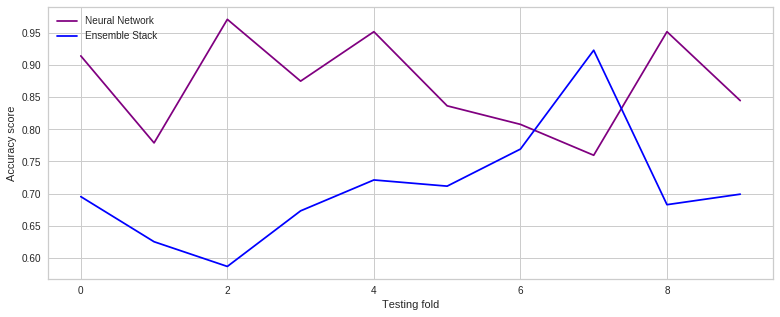

In [176]:
plt.figure(figsize=(13, 5))
plt.plot(hypo_df['NN_Scores'], color='purple')
plt.plot(hypo_df['Stacking_Scores'], color='blue')
plt.legend(("Neural Network", "Ensemble Stack"))
plt.xlabel("Testing fold")
plt.ylabel("Accuracy score")
plt.savefig("final.png", dpi=400)

### ROC curve for Stack 

In [72]:
y_train

Date
1998-02-23    2
1998-02-24    2
1998-02-25    2
1998-02-26    2
1998-02-27    2
1998-03-02    2
1998-03-03    2
1998-03-04    2
1998-03-05    2
1998-03-06    1
1998-03-09    1
1998-03-10    2
1998-03-11    2
1998-03-12    2
1998-03-13    2
1998-03-16    2
1998-03-17    2
1998-03-18    1
1998-03-19    1
1998-03-20    1
1998-03-23    1
1998-03-24    1
1998-03-25    2
1998-03-26    2
1998-03-27    2
1998-03-30    1
1998-03-31    1
1998-04-01    1
1998-04-02    2
1998-04-03    2
1998-04-06    2
1998-04-07    2
1998-04-08    1
1998-04-09    1
1998-04-13    1
1998-04-14    1
1998-04-15    1
1998-04-16    1
1998-04-17    1
1998-04-20    1
1998-04-21    1
1998-04-22    2
1998-04-23    1
1998-04-24    1
1998-04-27    0
1998-04-28    0
1998-04-29    0
1998-04-30    0
1998-05-01    1
1998-05-04    1
1998-05-05    1
1998-05-06    2
1998-05-07    0
1998-05-08    0
1998-05-11    0
1998-05-12    1
1998-05-13    2
1998-05-14    2
1998-05-15    2
1998-05-18    2
1998-05-19    2
1998-05-20    2
199

0.7102001906577693

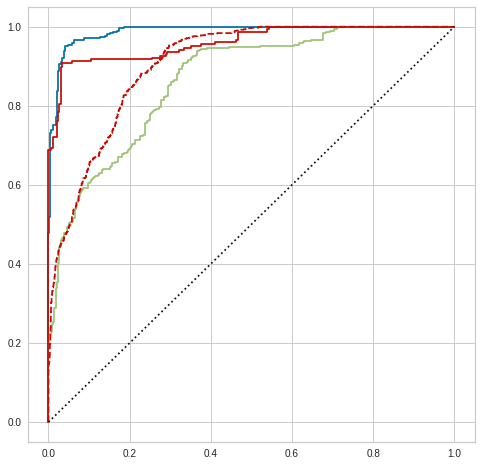

In [373]:
from yellowbrick.classifier import ROCAUC
plt.figure(figsize=(8,8))
classes = ["Bearish", "Bullish", "Reversal"]
visualizer = ROCAUC(xgc2, classes=classes, macro=False)
visualizer.fit(pca_Xtrain2, y_train)  # Fit the training data to the visualizer
visualizer.score(varimax_X, y_tester)# Evaluate the model on the test data
#g = visualizer.poof(outpath="stackroc.png")# Draw/show/poof the data

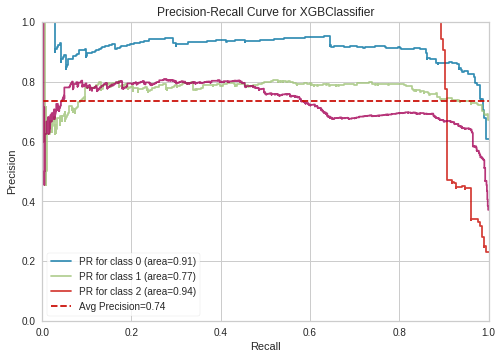

In [277]:
from yellowbrick.classifier import PrecisionRecallCurve
precision = PrecisionRecallCurve(xgc2, per_class=True, fill_area=False)
precision.fit(pca_Xtrain2, y_train)
precision.score(varimax_X, y_tester)
precision.poof()

In [212]:
0.05304043529286245/(0.06106848905968113 * np.sqrt(10))

0.27465651466881275

##  Performance Metrics 

### Confusion Matrix 

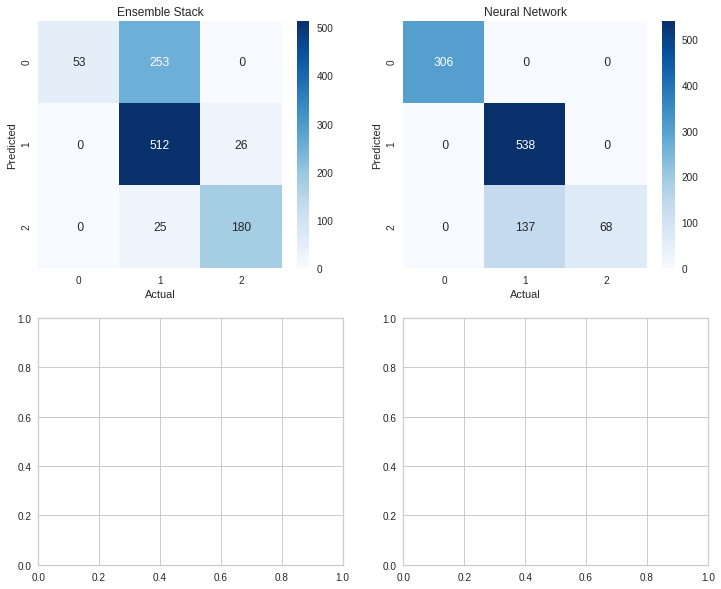

In [207]:
from sklearn.metrics import confusion_matrix
f,ax=plt.subplots(2, 2,figsize=(12, 10))

#Stack
sns.heatmap(confusion_matrix(y_tester, predz), annot=True, fmt='2.0f', ax=ax[0,0], cmap="Blues")
ax[0,0].set_ylabel('Predicted')
ax[0,0].set_xlabel('Actual')
ax[0,0].set_title('Ensemble Stack')

#Network 
sns.heatmap(confusion_matrix(y_tester, lolz), annot=True, fmt='2.0f', ax=ax[0,1], cmap="Blues")
ax[0,1].set_ylabel('Predicted')
ax[0,1].set_xlabel('Actual')
ax[0,1].set_title('Neural Network')
plt.savefig('confusion.png', dpi=300)

### Multiclass ROC 

In [310]:
from itertools import cycle 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

#First, binarize the outputs 
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
y_tester_binarized = label_binarize(y_tester, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

#Refit the model for the binary predictions 
model.fit(nn_Xtrain, Y)
binarized_score = model.predict(testing_NN)
#binarized_score = label_binarize(binarized_score, classes=[0, 1, 2])


#Compute ROC curve for eac class 
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_tester_binarized[:, i], binarized_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_tester_binarized.ravel(), binarized_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

Epoch 1/1
3356/3356 [==============================] - 0s 59us/step - loss: 0.3958 - acc: 0.8266


In [362]:
y_tester_binarized = label_binarize(y_tester, classes=[0, 1, 2])
lolz_binarized = label_binarize(predz, classes=[0, 1, 2])

In [475]:
fpr1, tpr1, thresholds1 = roc_curve(y_tester_binarized[:, 0], probabilities_test_nn[:, 0])
fpr2, tpr2, thresholds2 = roc_curve(y_tester_binarized[:, 1], probabilities_test_nn[:, 1])
fpr3, tpr3, thresholds3 = roc_curve(y_tester_binarized[:, 2], probabilities_test_nn[:, 2])

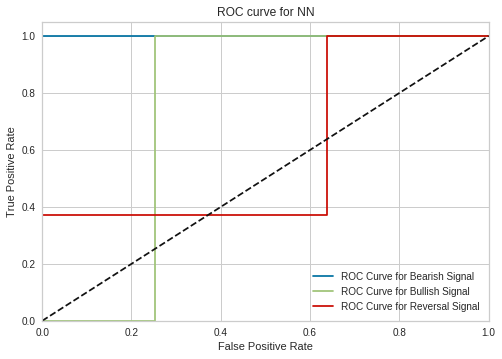

In [477]:

plt.plot(fpr1, tpr1)
plt.plot(fpr2, tpr2)
plt.plot(fpr3, tpr3)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve for NN")
plt.legend(("ROC Curve for Bearish Signal", "ROC Curve for Bullish Signal", "ROC Curve for Reversal Signal"))
plt.savefig('rostack.png', dpi=400)

### Precision-Recall curve

In [481]:
from sklearn.metrics import precision_recall_curve

precision1, recall1, _ = precision_recall_curve(y_tester_binarized[:, 0], probabilities_test_stack[:, 0])
precision2, recall2, _ = precision_recall_curve(y_tester_binarized[:, 1], probabilities_test_stack[:, 1])
precision3, recall3, _ = precision_recall_curve(y_tester_binarized[:, 2],probabilities_test_stack[:, 2])

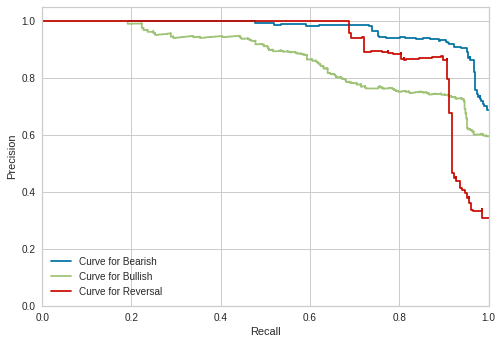

In [483]:
plt.step(recall1, precision1)
plt.step(recall2, precision2)
plt.step(recall3, precision3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(("Curve for Bearish", "Curve for Bullish", "Curve for Reversal"))
plt.savefig('prstack.png', dpi=400)

## Classification Report 

In [274]:
#Classification report for Stack 
from sklearn.metrics import classification_report
print(classification_report(y_tester, predz))

              precision    recall  f1-score   support

           0       1.00      0.17      0.30       306
           1       0.65      0.95      0.77       538
           2       0.87      0.88      0.88       205

   micro avg       0.71      0.71      0.71      1049
   macro avg       0.84      0.67      0.65      1049
weighted avg       0.79      0.71      0.65      1049



In [178]:
#Classification report for NN 
print(classification_report(y_tester, lolz))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       306
           1       0.80      1.00      0.89       538
           2       1.00      0.33      0.50       205

   micro avg       0.87      0.87      0.87      1049
   macro avg       0.93      0.78      0.80      1049
weighted avg       0.90      0.87      0.84      1049



## Confusion Matrix metrics for both the classifiers

In [73]:
from pycm import * 

matrixstats_nn = ConfusionMatrix(np.array(y_tester), np.array(lolz))
matrixstats_stack = ConfusionMatrix(np.array(y_tester), np.array(predz))

In [74]:
print(matrixstats_stack)

Predict          0      1      2      
Actual
0                53     253    0      

1                0      512    26     

2                0      25     180    





Overall Statistics : 

95% CI                                                           (0.68275,0.73765)
AUNP                                                             0.71258
AUNU                                                             0.73801
Bennett S                                                        0.5653
CBA                                                              0.56503
Chi-Squared                                                      872.71904
Chi-Squared DF                                                   4
Conditional Entropy                                              0.44174
Cramer V                                                         0.64496
Cross Entropy                                                    1.92507
Gwet AC1                                                         0.60527

In [75]:
print(matrixstats_nn)

Predict          0      1      2      
Actual
0                306    0      0      

1                0      538    0      

2                0      137    68     





Overall Statistics : 

95% CI                                                           (0.84901,0.88979)
AUNP                                                             0.86595
AUNU                                                             0.84393
Bennett S                                                        0.8041
CBA                                                              0.70958
Chi-Squared                                                      1326.33779
Chi-Squared DF                                                   4
Conditional Entropy                                              0.17914
Cramer V                                                         0.7951
Cross Entropy                                                    1.6161
Gwet AC1                                                         0.81814
